# Использование BERT для задачи классификации последовательности


### Домашнее задание #4. Применение бертоподобных моделей к задаче классификации

Решите задачу классификации по тональности на подготовленном в тетрадке корпусе отзывов Google Play, либо на корпусе IMDB, используя пайплайн с Trainer от HuggingFace.

1. обучите ту модель, которую мы разбирали на занятии (класс SentimentClassifier из тетрадки) -- 2 балла

2. измените модель, чтобы помимо выхода с пуллер-слоя использовался эмбеддинг cls-токена с последнего слоя. -- 3 балла

3. примените к данным готовую модель для классификации последовательности (типа BertForSequenceClassification) -- 2 балла

*4. агрегируйте cls-токены для нескольких слоев, чтобы сделать предсказание класса -- 2 дополнительных балла

5. выберите на сайте google play три понравившихся вам отзыва, относящиеся к разным классам. Покажите, как на них работает любая из обученных моделей -- 2 балла

Общие требования: (1 балл) Для всех моделей используйте одинаковые гиперпараметры, чтобы их результаты можно было сравнить между собой.

Комментируйте ваши решения в коде.

Для каждой из моделей нужно привести результаты на тестовой выборке.

Вы можете использовать любую предобученную модель, которая подходит для работы с английским, кроме bert-base-cased

Наша сегодняшняя задача - классификация отзывов.
Данные - отзывы на приложения в Google Play, классы:  negative (1,2), neutral (3), positive (4,5) 

## Загрузка данных

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import PreTrainedTokenizerFast
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

from transformers import BertModel, BertTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

from transformers import pipeline

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 6

In [4]:
df = pd.read_csv("reviews.csv")

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

df

Бертоподобных моделей огромное множество, но если они интегрированы в библиотеку Transformers, сменить одну модель на другую очень просто. Вот [здесь](https://huggingface.co/transformers/pretrained_models.html) можно посмотреть, какие модели есть библиотеке. 

Model id в таблице используются для двух вещей - подгрузки весов в саму модель и подгрузки правильного токенизатора. Вам не нужно самим добавлять спецсимволы и строить индексы словаря, это сделает токенайзер, соотвествующий выбранной модели.
Сегодняшний выбор - модель 'bert-base-cased'

In [16]:
path = './rubert-tiny/'
tokenizer = BertTokenizer.from_pretrained(path)

#PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Загрузим предобученный [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [22]:
#tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Посмотрим, как работает модель токенизации для BERT.



In [18]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'st', '##uck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1972, 560, 45, 2094, 4643, 35, 45, 782, 9127, 10139, 585, 1713, 567, 22, 6067, 18]


In [24]:
sample_txt = 'He started a new book, it was quite readable'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: He started a new book, it was quite readable
   Tokens: ['He', 'started', 'a', 'new', 'book', ',', 'it', 'was', 'quite', 'read', '##able']
Token IDs: [1124, 1408, 170, 1207, 1520, 117, 1122, 1108, 2385, 2373, 1895]


Установим максимальную длину последовательности равной 160

In [6]:
MAX_LEN = 160

Теперь создадим датасет PyTorch, который понадобится в дальнейшем для обучения модели

In [24]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Разделим данные на обучающую, тестовую и валидационную выборки 

In [7]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cpu')

In [9]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [11]:
class CustomDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=160):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True,
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }


BATCH_SIZE = 16
MAX_LEN = 160


In [12]:
path = './rubert-tiny/'
tokenizer = BertTokenizer.from_pretrained(path)

test_set = CustomDataset(df_test['content'], df_test['sentiment'], tokenizer)
test_data_loader = DataLoader(test_set, batch_size=16, shuffle=True)


In [15]:
def DL(df):
    return df['content'].values, df['sentiment'].values

texts, targets = DL(df_train)
train_set = CustomDataset(texts, targets, tokenizer)
train_data_loader = DataLoader(test_set, batch_size=16, shuffle=True)

texts, targets = DL(df_val)
val_set = CustomDataset(texts, targets, tokenizer)
val_data_loader = DataLoader(test_set, batch_size=16, shuffle=True)

texts, targets = DL(df_test)
test_set = CustomDataset(texts, targets, tokenizer)
test_data_loader = DataLoader(test_set, batch_size=16, shuffle=True)


In [ ]:
next(iter(train_data_loader))

In [17]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))


Создадим итераторы по данным
- train_data_loader - данные для обучения
- val_data_loader - данные для валидации модели при обучении
- test_data_loader - данные для тестирования модели

In [29]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1
  )

In [30]:
BATCH_SIZE = 16

#train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
#val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
#test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Посмотрим на пример одного батча из нашего итератора train_data_loader



In [38]:
data = next(iter(train_data_loader))

In [39]:
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [42]:
#print(data['text'])
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [43]:
data['targets']

tensor([0, 1, 0, 0, 0, 0, 1, 2, 2, 0, 2, 2, 0, 2, 2, 2])

# 3. примените к данным готовую модель для классификации последовательности (типа BertForSequenceClassification) -- 2 балла

In [50]:
pipe = pipeline("sentiment-analysis", 
                model="finiteautomata/bertweet-base-sentiment-analysis")

Downloading:   0%|          | 0.00/890 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/515M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji


In [52]:
data = ["I love you", "I hate you"]

In [75]:
%%time
pipe(data)

Wall time: 36.7 s


[{'label': 'POS', 'score': 0.9903132915496826},
 {'label': 'NEG', 'score': 0.9797351360321045}]

In [88]:
texts, targets = DL(df_test)

In [107]:
yy = []
rr = []
i = -1
for t in tqdm(list(texts)):
    i += 1
    y = targets[i]
    if y == 0:
        y1 = 0
    elif y == 2:
        y1 = 1
    elif y == 1:
        continue
    if len(t) > 160:
        t = t[0:160]
    try: 
        out = pipe(t)
    except:
        print('ERROR', i, t)
    rr += [out]
    yy += [y1]

  0%|          | 0/788 [00:00<?, ?it/s]

ERROR 718 Слишком сложно, но при этом нет того, что нужно. Очень много возможностей, но не смог элементарно сделать TODO список на _каждый_ день. И постоянно лезут с пред


In [112]:
def y_pred(rr):
    yy = []
    for r in rr:
        label = r[0]['label']
        if label == 'POS':
                  y = 1
        elif label == 'NEG':
                  y = 0
        yy += [y]
    return yy

In [113]:
yy2 = y_pred(rr)

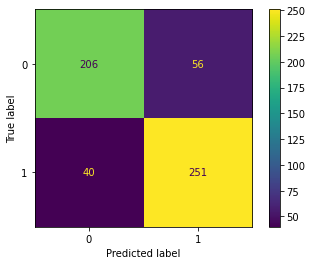

In [118]:
cm = confusion_matrix(yy, yy2)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [121]:
print(metrics.accuracy_score(yy, yy2))
print(metrics.f1_score(yy, yy2))

0.8264014466546112
0.8394648829431439



В библиотеке Transformers от Hugging Face есть много моделей для разных задач: [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) и другие. Все они являются надстройками над базовой моделью BERT.

В данном случае мы будем использовать базовую модель [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) и реализуем на её основе свой классификатор текстов по тональности.

In [18]:
NAME2 = 'bert-base-uncased'
tokenizer2 = BertTokenizer.from_pretrained(NAME2)
bert_model2 = BertModel.from_pretrained(NAME2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [45]:
#bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

model_path = './rubert-tiny/'
bert_model = BertForSequenceClassification.from_pretrained(model_path)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./rubert-tiny/ and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [133]:
bert_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, element

Попробуем использовать эту модель 

In [19]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [ ]:
token_ids

In [21]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

In [142]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [23]:
configuration = bert_model2.config
configuration

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [24]:
last_hidden_state, pooled_output, hidden_states = bert_model2( 
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
  output_hidden_states=True,
  return_dict=False)


В переменную last_hidden_state теперь записана последовательность скрытых состояний последнего слоя модели. 

In [180]:
print(last_hidden_state.shape)
print(pooled_output.shape)
print(len(hidden_states))

torch.Size([1, 32, 768])
torch.Size([1, 768])
13


In [181]:
for state in hidden_states:
  print(state.shape)

torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 32, 768])


Посмотрим на BERT эмбеддинги некоторых слов в предложениях.

In [ ]:
text1 = df.loc[16]['content']
text2 = df.loc[338]['content']
print(text1)
print(text2)

Couldn't even set up one single recurring reminder without being required to pay monthly subscription. Get your greedy hand off it dev. It's only only a reminder app not a useful service.
Well designed and all however alot of the crutial features are locked behind the premium which u need to pay for


In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer2 = PreTrainedTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
tokenizer2.sep_token = tokenizer.sep_token
tokenizer2.pad_token = tokenizer.pad_token

In [ ]:
encoding = tokenizer.encode_plus(
  text1,
  max_length=30,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True
)

In [ ]:
encoding2 = tokenizer2.encode_plus(
  text1,
  max_length=50,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True,
  return_offsets_mapping=True
)

In [ ]:
print(encoding.keys())
print(encoding2.keys())

dict_keys(['input_ids', 'attention_mask'])
dict_keys(['input_ids', 'attention_mask', 'offset_mapping'])


In [ ]:
encoding2['offset_mapping']

tensor([[[  0,   0],
         [  0,   6],
         [  6,   7],
         [  7,   8],
         [  9,  13],
         [ 14,  17],
         [ 18,  20],
         [ 21,  24],
         [ 25,  31],
         [ 32,  41],
         [ 42,  50],
         [ 51,  58],
         [ 59,  64],
         [ 65,  73],
         [ 74,  76],
         [ 77,  80],
         [ 81,  88],
         [ 89, 101],
         [101, 102],
         [103, 106],
         [107, 111],
         [112, 118],
         [119, 123],
         [124, 127],
         [128, 130],
         [131, 133],
         [133, 134],
         [134, 135],
         [136, 138],
         [138, 139],
         [139, 140],
         [141, 145],
         [146, 150],
         [151, 152],
         [153, 161],
         [162, 165],
         [166, 169],
         [170, 171],
         [172, 178],
         [179, 186],
         [186, 187],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0

In [ ]:
encoding['input_ids']

tensor([[  101, 23320,   112,   189,  1256,  1383,  1146,  1141,  1423, 10993,
         15656,  1443,  1217,  2320,  1106,  2653,  7868, 16759,   119,  3949,
          1240, 24007,  1289,  1228,  1122,  1260,  1964,   119,  1135,   102]])

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
  return_dict=False)

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'Couldn', "'", 't', 'even', 'set', 'up', 'one', 'single', 'recurring', 'reminder', 'without', 'being', 'required', 'to', 'pay', 'monthly', 'subscription', '.', 'Get', 'your', 'greedy', 'hand', 'off', 'it', 'de', '##v', '.', 'It', '[SEP]']


In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]).index('subscription')

17

In [ ]:
emb1 = last_hidden_state[0, 17]
emb1.shape

torch.Size([768])

In [ ]:
encoding2 = tokenizer.encode_plus(
  text2,
  max_length=30,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True
)

last_hidden_state2, pooled_output2 = bert_model(
  input_ids=encoding2['input_ids'], 
  attention_mask=encoding2['attention_mask'],
  return_dict=False)

In [ ]:
tokenizer.convert_ids_to_tokens(encoding2['input_ids'][0])

['[CLS]',
 'Well',
 'designed',
 'and',
 'all',
 'however',
 'al',
 '##ot',
 'of',
 'the',
 'c',
 '##ru',
 '##tial',
 'features',
 'are',
 'locked',
 'behind',
 'the',
 'premium',
 'which',
 'u',
 'need',
 'to',
 'pay',
 'for',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
tokenizer.convert_ids_to_tokens(encoding2['input_ids'][0]).index('premium')

18

In [ ]:
emb2 = last_hidden_state2[0, 1]
emb2.shape

torch.Size([768])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cosine_similarity( [emb1.detach().cpu().numpy()], [emb2.detach().cpu().numpy()])

array([[0.50464517]], dtype=float32)

# 1. обучите ту модель, которую мы разбирали на занятии (класс SentimentClassifier из тетрадки) -- 2 балла

In [183]:
bert_model2.config.hidden_size

768

Опишем наконец наш классификатор на основе BertModel

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained(NAME2)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

class_names = ['negative', 'neutral', 'positive']
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [185]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

Перенесем на GPU один из наших батчей (для примера).

In [187]:
data = next(iter(train_data_loader))

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


Применим модель к данным.

In [188]:
output = model(input_ids, attention_mask)
output

tensor([[-9.7733e-02, -5.7299e-01,  1.9467e-01],
        [-4.7401e-02,  3.9245e-01,  2.3256e-01],
        [-1.4405e-01,  2.1426e-01,  7.7787e-04],
        [ 1.2292e-01, -3.5040e-01,  3.7009e-01],
        [ 1.9006e-01, -3.1937e-01,  8.0763e-02],
        [-1.0356e-01, -9.7931e-01,  5.9586e-01],
        [-1.8509e-01, -1.1297e+00,  6.9764e-01],
        [-3.0023e-01, -1.4054e+00,  6.1074e-01],
        [ 7.6563e-02, -8.3484e-01,  2.4541e-01],
        [ 2.4702e-01, -9.8489e-01,  2.6985e-01],
        [-5.5363e-02, -7.9687e-01,  5.6798e-01],
        [ 5.5121e-02, -6.0164e-01,  7.5356e-01],
        [-4.6290e-02, -1.0051e+00,  6.6914e-02],
        [ 2.0870e-01, -7.1406e-01,  2.2242e-01],
        [ 2.1225e-02, -9.0184e-01,  7.6337e-01],
        [ 7.9370e-02, -8.2046e-01,  2.5652e-01]], grad_fn=<AddmmBackward0>)

Если хотим получить вероятности классов, применяем SoftMax к выходу модели.

In [189]:
F.softmax(output, dim=1)

tensor([[0.3377, 0.2099, 0.4524],
        [0.2580, 0.4006, 0.3414],
        [0.2788, 0.3989, 0.3223],
        [0.3444, 0.2146, 0.4410],
        [0.4004, 0.2406, 0.3590],
        [0.2916, 0.1215, 0.5869],
        [0.2627, 0.1022, 0.6351],
        [0.2619, 0.0867, 0.6513],
        [0.3867, 0.1554, 0.4578],
        [0.4320, 0.1260, 0.4420],
        [0.2993, 0.1426, 0.5582],
        [0.2834, 0.1469, 0.5697],
        [0.3995, 0.1531, 0.4474],
        [0.4147, 0.1648, 0.4205],
        [0.2859, 0.1136, 0.6005],
        [0.3845, 0.1564, 0.4591]], grad_fn=<SoftmaxBackward0>)

## Обучение модели

Для дообучения модели будем использовать оптимизатор [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) из библиотеки Hugging Face. 



Авторы модели BERT рекомендуют использовать следующие параметры для дообучения модели:
- Размер батча: 16, 32
- Learning rate (с оптимайзером Adam): 5e-5, 3e-5, 2e-5
- Количество эпох: 2, 3, 4

In [190]:

#как заморозить отдельные слои
freeze_layers = list(range(5))
for layer_id in freeze_layers:
  for param in list(model.bert.encoder.layer[layer_id].parameters()):
    param.requires_grad = False


In [191]:
list(model.bert.encoder.layer[3].parameters())[0]

Parameter containing:
tensor([[ 0.0586, -0.0279,  0.0022,  ..., -0.0205,  0.0419,  0.0560],
        [-0.0011,  0.1283, -0.0564,  ..., -0.0514, -0.0199,  0.0516],
        [-0.0083,  0.0060, -0.0469,  ...,  0.0569, -0.0073, -0.0616],
        ...,
        [ 0.0118,  0.0645, -0.0159,  ..., -0.0027, -0.0031, -0.0141],
        [ 0.0029,  0.0531,  0.0221,  ..., -0.0047,  0.0399,  0.0344],
        [ 0.0512,  0.0246,  0.0077,  ...,  0.0108,  0.0262,  0.0081]])

In [192]:
EPOCHS = 2

#optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [193]:
1+1

2

Реализуем функцию для одной эпохи обучения

In [55]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    preds = torch.argmax(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions / n_examples, np.mean(losses)

Также реализуем функцию для оценки качества модели на данных из data_loader

In [54]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions / n_examples, np.mean(losses)

Используя эти две функции, описанные выше, реализуем процедуру дообучения нашей модели 

In [200]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------
Train loss 1.1318932950496674 accuracy 0.01982922852039337
Val loss 1.1040610623359681 accuracy 0.33290979266166687

Epoch 2/2
----------
Train loss 1.1228202486038208 accuracy 0.019264696165919304
Val loss 1.0930102801322936 accuracy 0.36975857615470886

Wall time: 25min 2s



При обучении модели мы сохраняем веса наилучшей модели на основе точности на валидационной выборке.

Обучение модели занимает некоторое время. Теперь мы можем сравнить точность на валидационной и на обучающей выборке.

In [201]:
history['train_acc'] = [score.to('cpu') for score in  history['train_acc']]
history['val_acc'] = [score.to('cpu') for score in  history['val_acc']]

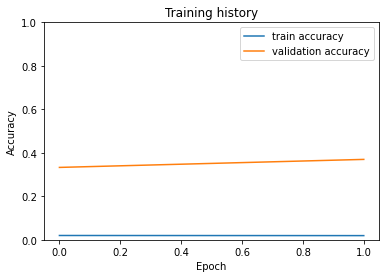

In [202]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
'''
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)
'''

## Оценка результатов работы модели

Подсчитаем точность (accuracy) модели на тестовой выборке.

In [203]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.3692893385887146

Accuracy на тестовых данных и на валидационной выборке дают близкие значения. Из этого можно сделать вывод, что получившаяся модель обладает хорошей обобщающей способностью.

Теперь реализуем вспомогательную функцию, которая будет получать предсказания из нашей модели.

In [68]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
 next(iter(test_data_loader))

In [210]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

Давайте посмотрим на результаты работы модели на тестовой выборке.

In [211]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       262
     neutral       0.00      0.00      0.00       235
    positive       0.37      1.00      0.54       291

    accuracy                           0.37       788
   macro avg       0.12      0.33      0.18       788
weighted avg       0.14      0.37      0.20       788



#### Выводы. Точность составила 0.37 вместо 0.71. Это можно объяснить обучением только двух эпох вместо десяти в оригинале. Прогресс обучения достаточно перспективный, целевая точность вполне может быть достигнута на этой модели.

In [ ]:
# Старое
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.74      0.69      0.72       262
     neutral       0.55      0.59      0.57       235
    positive       0.81      0.81      0.81       291

    accuracy                           0.71       788
   macro avg       0.70      0.70      0.70       788
weighted avg       0.71      0.71      0.71       788



Из данного отчета видно, что сложнее всего классифицировать нейтральные отзывы. 

Посмотрим также на confusion matrix предсказаний модели на тестовой выборке.

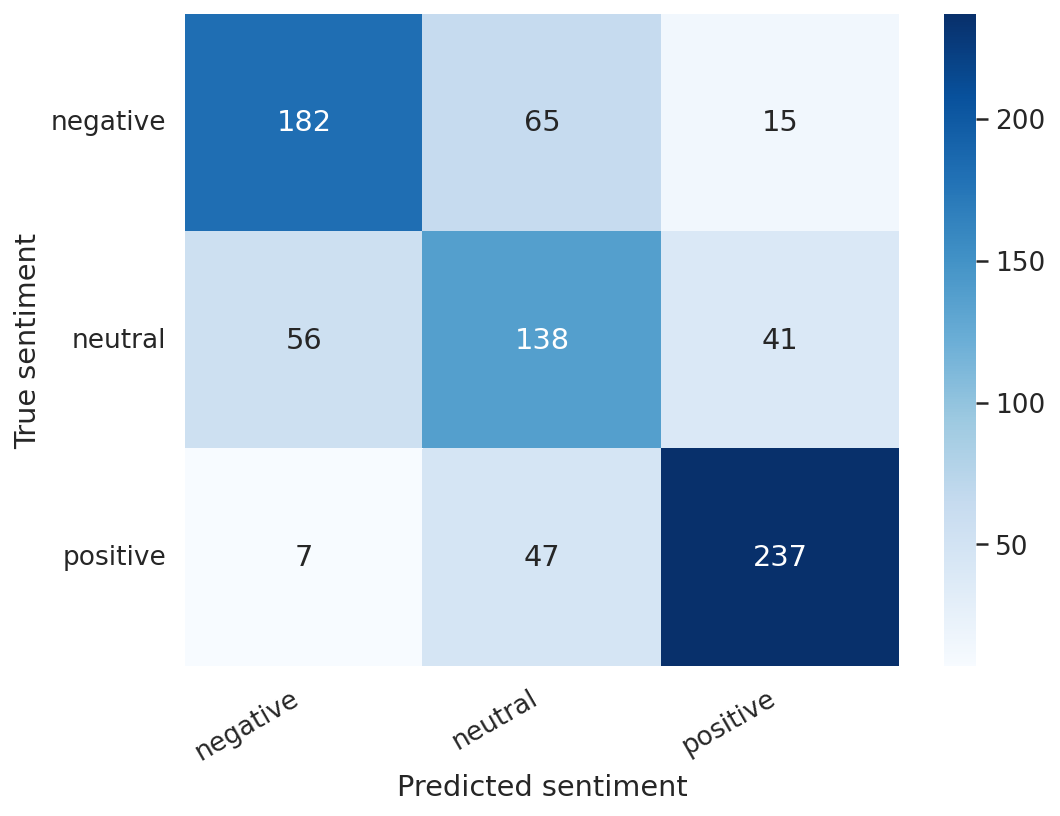

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Здесь также можно видеть, что модели сложнее всего классифицировать нейтральные отзывы. 

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Good

True sentiment: negative


## Предсказание на произвольных текстах

Теперь нам осталось научиться использовать нашу модель для предсказания тональности любого текста.

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

Для использования нашей модели нам следует токенизировать текст соответствующим образом.

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

Теперь получим предсказания нашей модели.

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
prediction = torch.argmax(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive


# 5. выберите на сайте google play три понравившихся вам отзыва, относящиеся к разным классам. Покажите, как на них работает любая из обученных моделей -- 2 балла

In [27]:
t2 = "The best way to say thank you to the birds. It's great."
t1 = "Stop mixing politics with education. Rearrange the avatar to a normal, neutral one, without political hints."
t0 = "Mobile version - sadness. The main disadvantage is the lack of support for extensions (adblock, etc.). It's a shame."

In [214]:
MAX_LEN

160

In [ ]:
text = t0
encoded_review = tokenizer.encode_plus(
  text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
prediction = torch.argmax(output, dim=1)
print(f'Review text: {text}')
print(f'Sentiment  : {class_names[prediction]}')

In [216]:
text = t1
encoded_review = tokenizer.encode_plus(
  text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
prediction = torch.argmax(output, dim=1)
print(f'Review text: {text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Stop mixing politics with education. Rearrange the avatar to a normal, neutral one, without political hints.
Sentiment  : positive


In [217]:
text = t2
encoded_review = tokenizer.encode_plus(
  text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
prediction = torch.argmax(output, dim=1)
print(f'Review text: {text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: The best way to say thank you to the birds. It's great.
Sentiment  : positive


#### Пока что результаты далеки от желаемого. Сеть работает очень хорошо, без ошибок, но на все тексты выдает класс 2. Задание 5 выполнено.

# 2. измените модель, чтобы помимо выхода с пуллер-слоя использовался эмбеддинг cls-токена с последнего слоя. -- 3 балла

In [29]:
aa = bert_model2(input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=True)

In [30]:
aa.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [31]:
last_hidden_state = aa['last_hidden_state']
pooler_output = aa['pooler_output']

In [32]:
print(last_hidden_state.shape)
print(pooler_output.shape)

torch.Size([1, 160, 768])
torch.Size([1, 768])


In [ ]:
pooler_output

In [37]:
bb = last_hidden_state[:, 0]

In [38]:
bb.shape

torch.Size([1, 768])

In [35]:
bert_model2

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [36]:
3072/768


4.0

In [50]:
class SentimentClassifier2(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained(NAME2)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out2 = nn.Linear(2*self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    last_hidden_state, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    #output = self.drop(pooled_output)
    output = torch.cat((pooled_output, last_hidden_state[:, 0]), 1)
    output = self.drop(output)    
    return self.out2(output)

class_names = ['negative', 'neutral', 'positive']
model2 = SentimentClassifier2(len(class_names))
model2 = model2.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
print(pooled_output.shape)
print(last_hidden_state[:, 0].shape)
x = torch.cat((pooled_output, last_hidden_state[:, 0]), 1)
print(x.shape)

torch.Size([1, 768])
torch.Size([1, 768])
torch.Size([1, 1536])


In [51]:
#как заморозить отдельные слои
freeze_layers = list(range(5))
for layer_id in freeze_layers:
  for param in list(model2.bert.encoder.layer[layer_id].parameters()):
    param.requires_grad = False

In [57]:
EPOCHS = 4
optimizer = AdamW(filter(lambda p: p.requires_grad, model2.parameters()), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [58]:
%%time

history2 = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model2,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model2,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history2['train_acc'].append(train_acc)
  history2['train_loss'].append(train_loss)
  history2['val_acc'].append(val_acc)
  history2['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model2.state_dict(), 'best_model2_state.bin')
    best_accuracy = val_acc


Epoch 1/4
----------
Train loss 1.152275823354721 accuracy 0.01891186274588108
Val loss 1.093891839981079 accuracy 0.4142312705516815

Epoch 2/4
----------
Train loss 1.1097220182418823 accuracy 0.019899794831871986
Val loss 1.0924722814559937 accuracy 0.4104193150997162

Epoch 3/4
----------
Train loss 1.1175803494453431 accuracy 0.019405828788876534
Val loss 1.086594624519348 accuracy 0.4167725443840027

Epoch 4/4
----------
Train loss 1.1018034648895263 accuracy 0.01919412799179554
Val loss 1.081420271396637 accuracy 0.37738245725631714

Wall time: 47min 58s


              precision    recall  f1-score   support

    negative       0.45      0.05      0.10       262
     neutral       0.00      0.00      0.00       235
    positive       0.37      0.97      0.54       291

    accuracy                           0.38       788
   macro avg       0.28      0.34      0.21       788
weighted avg       0.29      0.38      0.23       788



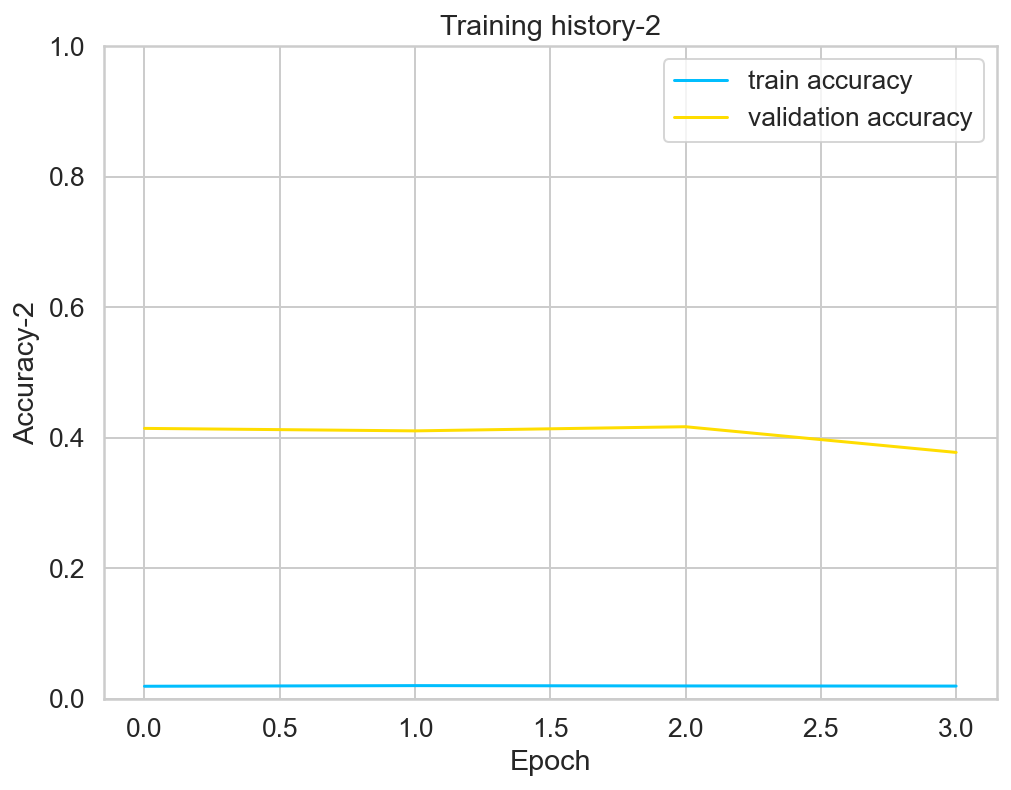

In [69]:
history2['train_acc'] = [score.to('cpu') for score in  history2['train_acc']]
history2['val_acc'] = [score.to('cpu') for score in  history2['val_acc']]

plt.plot(history2['train_acc'], label='train accuracy')
plt.plot(history2['val_acc'], label='validation accuracy')

plt.title('Training history-2')
plt.ylabel('Accuracy-2')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model2, test_data_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

# 4. агрегируйте cls-токены для нескольких слоев, чтобы сделать предсказание класса -- 2 дополнительных балла

In [70]:
last_hidden_state, pooled_output, hidden_states = bert_model2( 
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
  output_hidden_states=True,
  return_dict=False)

In [71]:
len(hidden_states)

13

In [75]:
hidden_states[-2].shape

torch.Size([1, 32, 768])

In [73]:
last_hidden_state

tensor([[[ 0.2548,  0.0235,  0.1127,  ...,  0.0598,  0.1190,  0.2941],
         [ 0.2378, -0.0675,  0.2470,  ...,  0.0702,  0.2085,  0.2459],
         [ 0.1589, -0.0186,  0.2244,  ...,  0.0619,  0.1809,  0.2897],
         ...,
         [ 0.2380,  0.0747,  0.1824,  ...,  0.0414,  0.0684,  0.2100],
         [ 0.2205,  0.0136,  0.2330,  ...,  0.0466,  0.1112,  0.2177],
         [ 0.1993,  0.0318,  0.2449,  ...,  0.0572,  0.1147,  0.2090]]],
       grad_fn=<NativeLayerNormBackward0>)

In [76]:
class SentimentClassifier3(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained(NAME2)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out2 = nn.Linear(2*self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    last_hidden_state, pooled_output, hidden_states = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      output_hidden_states=True,
      return_dict=False)
    #output = self.drop(pooled_output)
    output = torch.cat((hidden_states[-2][:,0], last_hidden_state[:, 0]), 1)
    output = self.drop(output)    
    return self.out2(output)

class_names = ['negative', 'neutral', 'positive']
model3 = SentimentClassifier3(len(class_names))
model3 = model3.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [77]:
#как заморозить отдельные слои
freeze_layers = list(range(5))
for layer_id in freeze_layers:
  for param in list(model3.bert.encoder.layer[layer_id].parameters()):
    param.requires_grad = False

In [78]:
EPOCHS = 4
optimizer = AdamW(filter(lambda p: p.requires_grad, model3.parameters()), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [79]:
%%time

history3 = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model3,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model3,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history3['train_acc'].append(train_acc)
  history3['train_loss'].append(train_loss)
  history3['val_acc'].append(val_acc)
  history3['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model3.state_dict(), 'best_model3_state.bin')
    best_accuracy = val_acc


Epoch 1/4
----------
Train loss 1.164115161895752 accuracy 0.020323194563388824
Val loss 1.1089685082435607 accuracy 0.3087674677371979

Epoch 2/4
----------
Train loss 1.1171458923816682 accuracy 0.019264696165919304
Val loss 1.0859426426887513 accuracy 0.36975857615470886

Epoch 3/4
----------
Train loss 1.1023570203781128 accuracy 0.019264696165919304
Val loss 1.0800778698921203 accuracy 0.41168996691703796

Epoch 4/4
----------
Train loss 1.1018460822105407 accuracy 0.018629595637321472
Val loss 1.0735917282104492 accuracy 0.43710291385650635

Wall time: 46min 52s


              precision    recall  f1-score   support

    negative       0.41      0.44      0.42       262
     neutral       0.00      0.00      0.00       235
    positive       0.45      0.79      0.57       291

    accuracy                           0.44       788
   macro avg       0.29      0.41      0.33       788
weighted avg       0.30      0.44      0.35       788



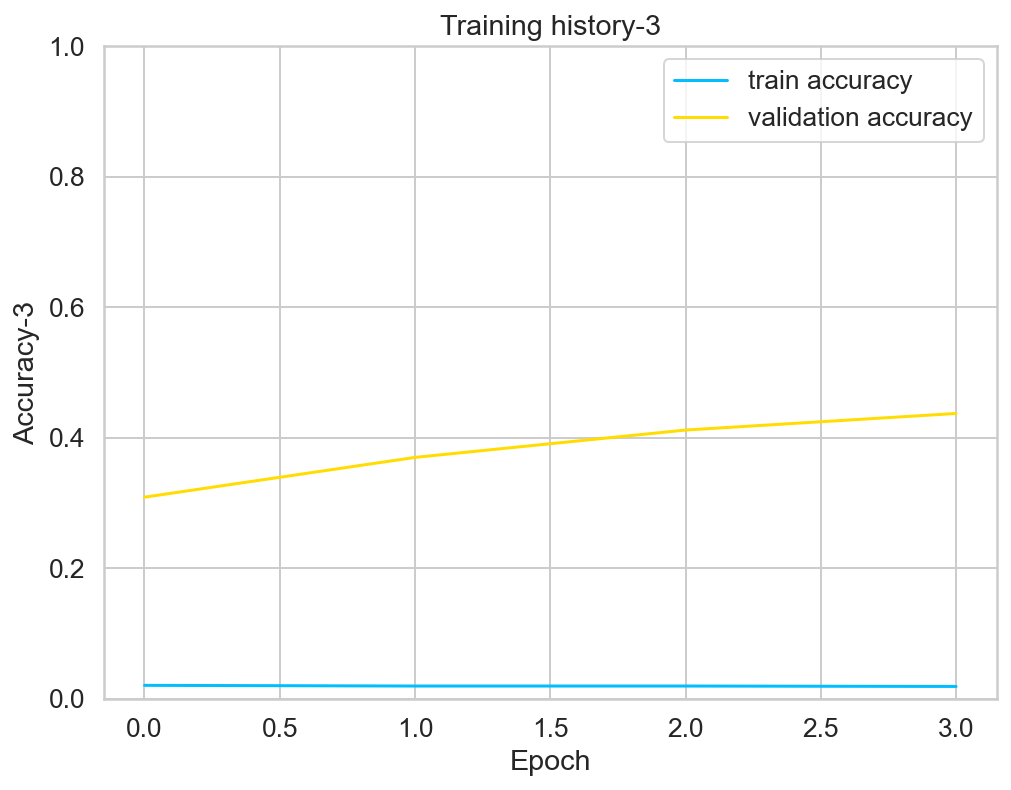

In [80]:
history3['train_acc'] = [score.to('cpu') for score in  history3['train_acc']]
history3['val_acc'] = [score.to('cpu') for score in  history3['val_acc']]

plt.plot(history3['train_acc'], label='train accuracy')
plt.plot(history3['val_acc'], label='validation accuracy')

plt.title('Training history-3')
plt.ylabel('Accuracy-3')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model3, test_data_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

## Trainer от HuggingFace

Библиотека HuggingFace предоставляет инструменты, которые упрощают обучение и оценку моделей, выложенных в репозиторий библиотеки. Рассмотрим эти инструменты на примере задачи анализа тональности. Будем обучать и оценивать модели на датасете imdb, состоящем из отзывов пользователей о фильмах. 

Оригинал: https://huggingface.co/transformers/custom_datasets.html#sequence-classification-with-imdb-reviews

Для загрузки датасета воспользуемся библиотекой datasets, реализованной HuggingFace. Данная библиотека предоставляет возможность быстро и удобно скачивать различные бенчмарки: https://huggingface.co/datasets

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

imdb_dataset = load_dataset('imdb')

Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
imdb_dataset["train"]["text"][:10]

['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, e

In [ ]:
imdb_dataset["train"]["label"][:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Сократим количество примеров, чтобы процесс обучения был быстрее.

In [ ]:
train_texts = imdb_dataset["train"]["text"][:2000]
train_labels = imdb_dataset["train"]["label"][:2000]
test_texts = imdb_dataset["test"]["text"][:1000]
test_labels = imdb_dataset["test"]["label"][:1000]

In [ ]:
del imdb_dataset

Выделим часть обучающих данных для оценки:

In [ ]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

Токенизируем данные

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Создадим класс Dataset, который на каждой итерации будет возвращать токенизированный отзыв и класс:

In [ ]:
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

Опишем функцию для подсчета метрик, которые хотим увидеть при оценке модели (по умолчанию будет вычисляться только loss):

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

Зададим параметры обучения с помощью TrainingArguments:

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

Инициализируем модель и запустим fine-tune ее с помощью модуля Trainer. В данном модуле будет автоматически происходить итерация по эпохам, батчам, рассчет функции потерь и градиентов, ничего этого больше руками прописывать не нужно!

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1600
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 400


Step,Training Loss
10,0.596000
20,0.571900
30,0.514700
40,0.402600
50,0.245100
60,0.125700
70,0.051300
80,0.024300
90,0.014200
100,0.009200




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=400, training_loss=0.0647397192819335, metrics={'train_runtime': 294.1987, 'train_samples_per_second': 10.877, 'train_steps_per_second': 1.36, 'total_flos': 423895675699200.0, 'train_loss': 0.0647397192819335, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

Оценим модель на тестовых данных

In [ ]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")